In [1]:
# import public packages
import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
import scipy
import mne
import sys

from mne.time_frequency import tfr_morlet
from mne.baseline import rescale
from mne.stats import permutation_cluster_test
from scipy.signal import spectrogram, hann, butter, filtfilt, hilbert
from scipy import signal, interpolate, stats
from scipy.interpolate import make_interp_spline, BSpline
from io import open
from importlib import reload

# import own functions
from utils import find_folders
import dat_preproc
import fix_annot_onsets
import mat2fif
import baseline_correction
import normalization
import anal_functions

### Add Directories/ Load Files

In [2]:
reload(find_folders)
onedrive = find_folders.get_onedrive_path()
project_path = find_folders.get_onedrive_path("entrainment")
print(project_path)

C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT


### Select Peaks and Plot Analytic Signal

In [99]:
#Load raw fif data

test_raw = mne.io.read_raw_fif(os.path.join(
    project_path,
        'data',
        'Fifs',
        'with_med_FTG',
        'Sub065_ARTREJECT_FIF.fif'
    )
)

subID = 'Sub065'
fft_name = str(subID) + '_'
print(fft_name)

Opening raw data file C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT\data\Fifs\with_med_FTG\Sub065_ARTREJECT_FIF.fif...
    Reading extended channel information
    Range : 0 ... 113699 =      0.000 ...   454.796 secs
Ready.
Sub065_


C:\Users\mathiopv\AppData\Local\Temp\ipykernel_11468\529687346.py:3: RuntimeWarning: This filename (C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT\data\Fifs\with_med_FTG\Sub065_ARTREJECT_FIF.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  test_raw = mne.io.read_raw_fif(os.path.join(


In [100]:
reload(dat_preproc)
x = test_raw.get_data() 
x1 = x[0,:]

peakMed = 80
peakStim = 63

dat_ngam = dat_preproc.low_highpass_filter(x1, peakMed-2, peakMed+2) 
dat_subh = dat_preproc.low_highpass_filter(x1, peakStim-2, peakStim+2) 
dat_inb = dat_preproc.low_highpass_filter(x1, peakStim+3, peakMed-3) 

datall = [dat_ngam, dat_subh, dat_inb] 
labels = ['Peak'+str(peakMed)+'Hz','Peak'+str(peakStim)+'Hz', str(peakStim+3) + '-' + str(peakMed-3)+'Hz']

#datall = [dat_subh] 
#labels = ['Peak'+str(peakStim)+'Hz']

print(labels)

['Peak80Hz', 'Peak63Hz', '66-77Hz']


In [101]:
def window_rms(a, window_size):
  a2 = np.power(a,2)
  window = np.ones(window_size)/float(window_size)
  return np.sqrt(np.convolve(a2, window, 'valid'))

In [102]:
%matplotlib qt
sm_signal_np = np.empty(shape = (3, x1.shape[0] - 499))
sm_signal_np[:] = np.nan

fig, axes = plt.subplots(1, 1, figsize=(12, 5))
wintosmooth = 500

for idx, dat in enumerate(datall):
    hiltr = hilbert(dat)
    amplitude_envelope = np.abs(hiltr)
    zscore_sign = stats.zscore(np.squeeze(amplitude_envelope))

    sm_signal = window_rms(zscore_sign, wintosmooth)
    
    plt.plot(sm_signal, label = labels[idx])
    #plt.plot(np.arange(0,75000), amplitude_envelope, label = labels[idx]) 
    
    #axes[idx].axvline(26250, color = 'b', ls='--', lw=2, label = 'Stim On')
    #axes[idx].axvline(50250, color = 'g', ls='--', lw=2, label = 'Stim Off')
    plt.ylabel('Analytic Signal')
    plt.xlim([0, sm_signal.shape[0]])

    
    sm_signal_np[idx,:] = sm_signal

    #axes[idx].set_xticks(ticks = np.arange(0, 80000, 10000), labels = np.arange(0,320,40))
    plt.xlabel('Time [sec]')

    

plt.suptitle('Smoothing Window: 500 samples')
plt.legend(loc='upper right')

plt.show()


In [103]:
x2 = x[4, :] 
sm_stim = window_rms(x2, wintosmooth)
sm_stim1 = (sm_stim)

In [104]:
fig, ax1 = plt.subplots(figsize = (18,6))
#plt.rcParams['font.size'] = 10
ax2 = ax1.twinx()
for idx, dat in enumerate(sm_signal_np):
    ax1.plot(sm_signal_np[idx,:], label = labels[idx], lw = 2)
ax2.plot(sm_stim1[:], label = 'Stimulation', color = 'grey', ls='--', lw=3, alpha = 0.4)
ax1.legend()
ax1.set_ylabel('Z-scored Smoothed Analytic Signal')
ax2.set_ylabel('Stimulation Amplitude [mA]')
#ax2.set_yticks(np.arange(0.5, 2.5, 0.25))
#ax2.set_yticklabels(np.arange(0.25, 2.25, 0.25))
#ax1.set_xlim(0, sm_signal_np.shape[0])
#ax1.set_xticks(np.arange(0, 100000, 20000))
#ax1.set_xticklabels(np.arange(0, 400, 80))
ax1.set_xlabel('Time [samples]')
plt.title(str(subID))
plt.show()

In [105]:
sm_analSignal = np.transpose(np.squeeze(np.array([[sm_signal_np[0]], [sm_signal_np[1]],[sm_signal_np[2]],[sm_stim1]])))
#sm_analSignal = np.transpose(np.squeeze(np.array([[sm_signal_np[0]],[sm_stim1]])))
sm_analSignal_df = pd.DataFrame(sm_analSignal, 
    columns = ['Spontan','StimOn','InBetween','StimVec'],
    )
print(sm_analSignal_df)

         Spontan    StimOn  InBetween  StimVec
0       1.054341  0.562997   1.288986      0.0
1       1.054652  0.562958   1.287942      0.0
2       1.054256  0.564084   1.287892      0.0
3       1.052994  0.565464   1.288239      0.0
4       1.051952  0.566688   1.288969      0.0
...          ...       ...        ...      ...
113196  1.502762  0.820121   0.770223      NaN
113197  1.503860  0.822183   0.770605      NaN
113198  1.505077  0.824352   0.770713      NaN
113199  1.505716  0.826316   0.770800      NaN
113200  1.506881  0.828477   0.772144      NaN

[113201 rows x 4 columns]


In [106]:
fft_fig = os.path.join(project_path, 'figures','anal_signal','with_med_FTG/')
fft_file = os.path.join(project_path, 'data','anal_signal','with_med_FTG/')

plt.savefig(str(fft_fig)+str(fft_name)+'sm_analSignal',dpi = 300)
sm_analSignal_df.to_csv(str(fft_file)+str(fft_name)+'sm_analSignal.csv')

### Crop Analytic Signal to Epochs of Interest

In [248]:
##Convert analytic signal arrays to mne objects:
anal_signal_df = pd.read_csv(os.path.join(
    project_path,
    'data',
    'anal_signal',
    'with_med_FTG',
    'Sub065_sm_analSignal.csv'
))

df_filtered = anal_signal_df.iloc[:, 1:]
dat_anal = df_filtered.values
ch_names = list(df_filtered.columns)
sfreq = 250
info = mne.create_info(ch_names, sfreq)
raw_anal = mne.io.RawArray(dat_anal.T, info)


Creating RawArray with float64 data, n_channels=4, n_times=113201
    Range : 0 ... 113200 =      0.000 ...   452.800 secs
Ready.


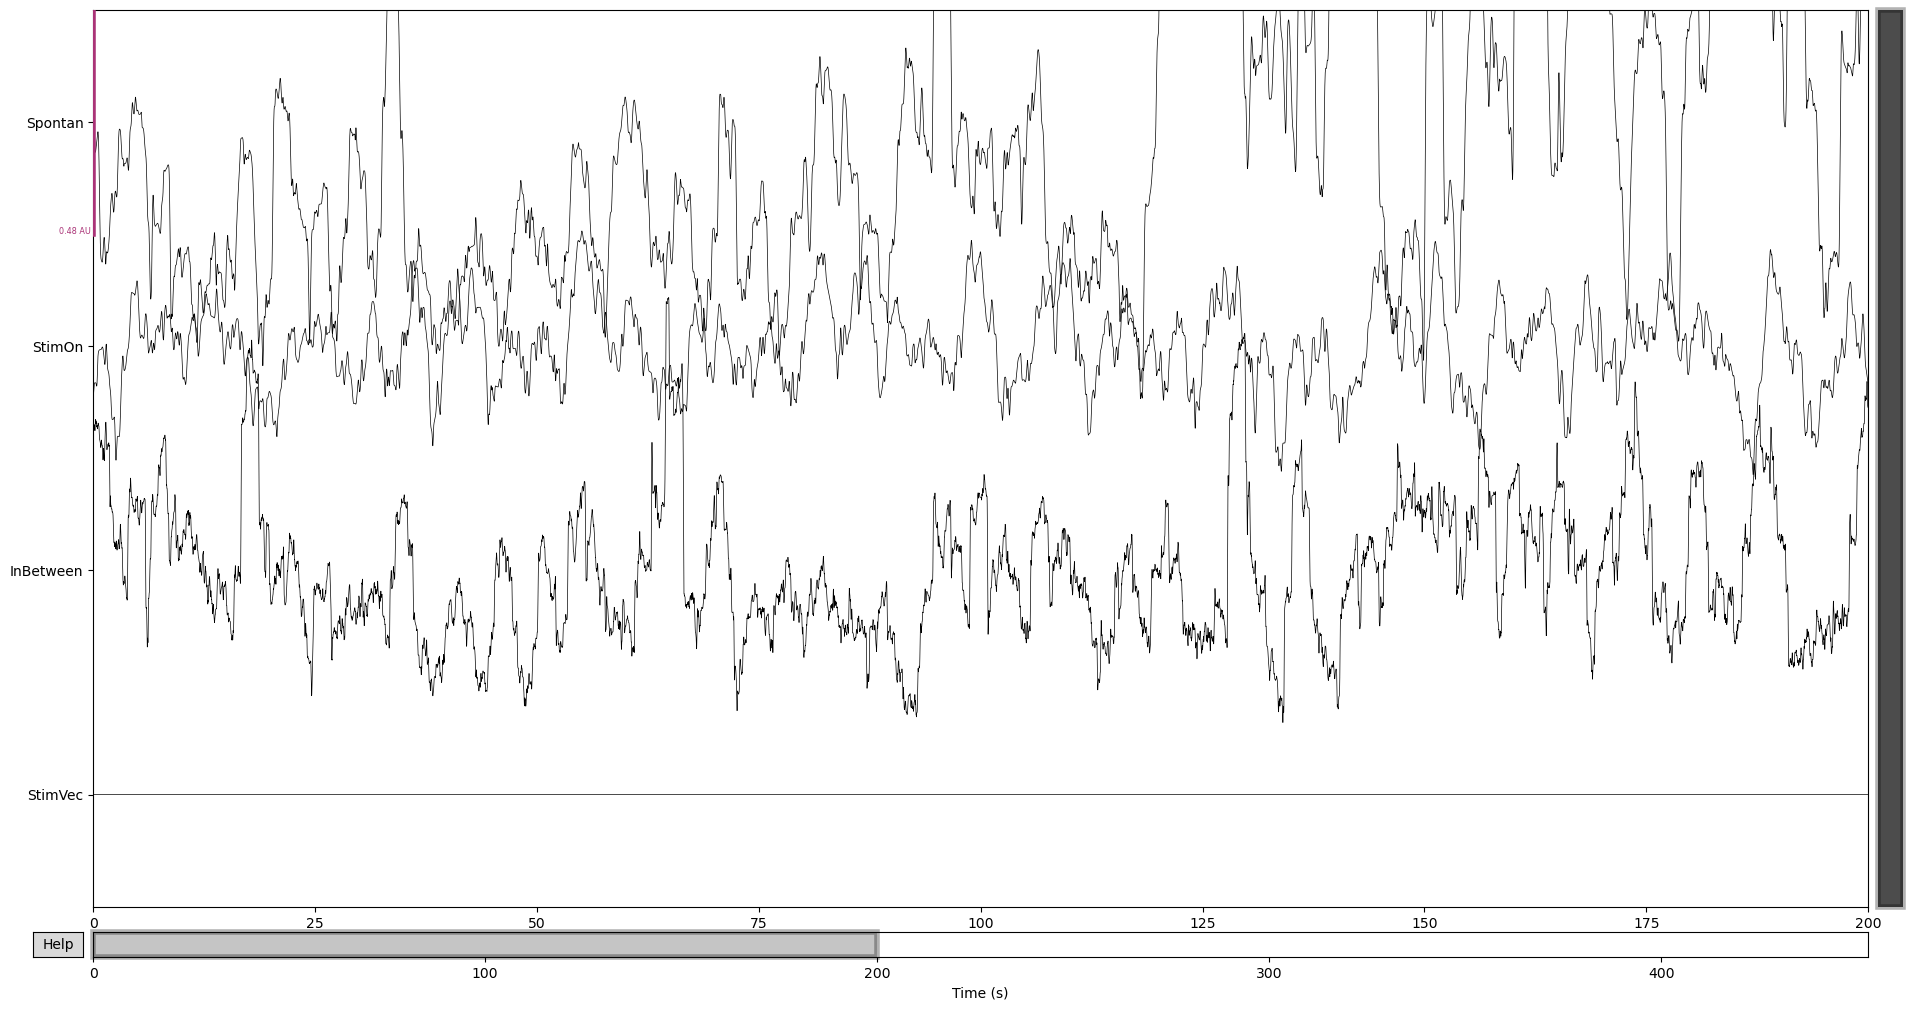

Channels marked as bad:
none


In [249]:
%matplotlib qt
raw_anal.plot(duration = 200)

In [250]:
fif_name = os.path.join(project_path, 'data','anal_signal','with_med_FTG','Sub065'+'_AnalFIF.fif')
print(fif_name)

C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT\data\anal_signal\with_med_FTG\Sub065_AnalFIF.fif


In [251]:
raw_anal.save(fif_name)

Writing C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT\data\anal_signal\with_med_FTG\Sub065_AnalFIF.fif
Closing C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT\data\anal_signal\with_med_FTG\Sub065_AnalFIF.fif
[done]


C:\Users\mathiopv\AppData\Local\Temp\ipykernel_11468\691688654.py:1: RuntimeWarning: This filename (C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT\data\anal_signal\with_med_FTG\Sub065_AnalFIF.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_anal.save(fif_name)


In [252]:
anal_epochs = pd.read_excel(os.path.join(
    project_path,
    'data', 'anal_signal',
    'Anal_epochs.xlsx'
))

anal_epochs
#subID = 'Sub005'
#fft_name = str(subID) + '_'
#print(fft_name)

,Percept_ID,Subh_On,preSub_On,Switch_Off
0,Sub005,279.537,138.311,361.148
1,Sub006,534.579,407.466,1023.902
2,Sub007,NaN,NaN,NaN
3,Sub009,644.723,514.354,667.762
4,Sub014,739.806,608.564,759.790
5,Sub017,222.195,147.549,327.998
6,Sub021,NaN,NaN,NaN
7,Sub025,NaN,NaN,NaN
8,Sub028,NaN,NaN,NaN
9,Sub029,125.749,65.015,281.606


In [253]:
anal_fif = mne.io.read_raw_fif(os.path.join(
    project_path,
        'data',
        'anal_signal',
        'with_med_FTG',
        'Sub065_AnalFIF.fif'
    )
)

subID = 'Sub065'

Opening raw data file C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT\data\anal_signal\with_med_FTG\Sub065_AnalFIF.fif...
Isotrak not found
    Range : 0 ... 113200 =      0.000 ...   452.800 secs
Ready.


C:\Users\mathiopv\AppData\Local\Temp\ipykernel_11468\3510633430.py:1: RuntimeWarning: This filename (C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT\data\anal_signal\with_med_FTG\Sub065_AnalFIF.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  anal_fif = mne.io.read_raw_fif(os.path.join(


In [254]:
reload(anal_functions)
cropped_anal_2tp = anal_functions.anal_transitions_2tp(anal_epochs, anal_fif, subID, 20)


In [255]:
anal_fig = os.path.join(project_path, 'figures','anal_signal', 'with_med_FTG/')
anal_file = os.path.join(project_path, 'data','anal_signal', 'with_med_FTG/')

plt.savefig(str(anal_fig) + str(subID)+'sm_analSignal2TP',dpi = 150)
np.save(str(anal_file) + str(subID)+'sm_analSignal2TP.npy', cropped_anal_2tp)

In [256]:
cropped_anal_1tp = anal_functions.anal_transitions_1tp(anal_epochs, anal_fif, subID, 20)

In [257]:
plt.savefig(str(anal_fig) + str(subID)+'sm_analSignal1TP',dpi = 150)
np.save(str(anal_file) + str(subID)+'sm_analSignal1TP.npy', cropped_anal_1tp)

### Average Cropped Analytic Signal and Plot

In [264]:
data.shape

(4, 10002)

In [268]:
# Specify the directory path
directory = os.path.join(
    project_path,
    'data',
    'anal_signal',
    'with_med_FTG'
)

# Find all .npy files in the directory ending with 'analSignal2TP.npy'
file_list = [file for file in os.listdir(directory) if file.endswith('analSignal2TP.npy')]

# Create an empty list to store the data arrays
data_list = []

# Loop through the file list and load the data
for file in file_list:
    data = np.load(os.path.join(directory, file))
    data_list.append(data[:, :10000])

# Concatenate the data arrays along the first axis
combined_data = np.concatenate(data_list, axis=0)

# Extract the first 10000 columns
extracted_data = combined_data[:, :10000]

# Calculate the mean and standard error of the mean along the first axis
mean_data = np.mean(extracted_data, axis=0)
sem_data = np.std(extracted_data, axis=0) / np.sqrt(extracted_data.shape[0])

# Plot the data
plt.figure(figsize=(12, 6))
x = np.arange(mean_data.shape[0])
plt.plot(x, mean_data, label='Mean')
plt.fill_between(x, mean_data - sem_data, mean_data + sem_data, alpha=0.3, label='Standard Error')


In [ ]:
all_med_anal_df = pd.DataFrame(med_anal)
all_stim_anal_df = pd.DataFrame(stim_anal)
all_med_anal_df.shape

In [ ]:
med_anal_cr = all_med_anal_df.loc[:, 1:7500] #all_med_anal_df.loc[:, 7500:17500]
med_anal_mean = np.nanmean(med_anal_cr,0)
med_anal_sem = stats.sem(med_anal_cr,0, nan_policy='omit')

stim_anal_cr = all_stim_anal_df.loc[:,  1:7500]
stim_anal_mean = np.nanmean(stim_anal_cr,0)
stim_anal_sem = stats.sem(stim_anal_cr,0, nan_policy='omit')


In [ ]:
med_anal_cr


In [ ]:
2000/250

In [ ]:
%matplotlib qt
plt.plot(np.arange(0,7500), med_anal_mean, label = 'Med-Induced FTG') #10000
plt.fill_between(np.arange(0,7500), med_anal_mean-med_anal_sem, med_anal_mean+med_anal_sem, alpha = 0.2)

plt.plot(np.arange(0,7500), stim_anal_mean, color = 'red', label = 'Stim-Induced FTG')
plt.fill_between(np.arange(0,7500), stim_anal_mean-stim_anal_sem, stim_anal_mean+stim_anal_sem, color = 'red', alpha = 0.2)


#plt.axvline(x = 6250, color = 'grey', ls='--', lw=3, alpha = 0.4, label = 'Subharmonic On')
#plt.axvline(x = 7500, color = 'grey', lw=3, alpha = 0.2)
#plt.xlim(0,10000)
#plt.xticks(np.arange(0,11250,1250), labels = np.arange(-25,20,5))
plt.xlim(0,2500)

plt.legend(loc = 'upper left')
plt.xlabel('Time [sec]')
plt.ylabel('Z-scored Smoothed Analytic Signal')

In [ ]:
fft_fig = os.path.join(project_path, 'results\\')

plt.savefig(str(fft_fig)+'AVG_AnalCropped_StimOn',dpi = 250)

In [ ]:
pval = 0.05  # arbitrary
dfn = 2 - 1  # degrees of freedom numerator
dfd = med_anal.shape[0] - 2  # degrees of freedom denominator
thresh = scipy.stats.f.ppf(1 - pval, dfn=dfn, dfd=dfd)  # F distribution
print(thresh)

In [ ]:
perm_nd = np.empty([6,med_anal.shape[0]])
perm_nd[:] = np.nan
perm_nd[0,:] = np.transpose(med_anal)

In [ ]:
y = np.expand_dims(med_anal, axis = 2)
y1 = np.expand_dims(stim_anal, axis = 2)


In [ ]:
#H0 = np.empty([1000,6])
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([y, y1], n_permutations=1000,
                             threshold=None, n_jobs=None)


In [ ]:
cluster_p_values

### Make all Signals same Length

In [ ]:
import traces


In [ ]:
sm_anal = pd.read_csv(os.path.join(
    project_path,
        'data',
        'anal_signal',
        'Sub005_sm_analSignal.csv'
))

print(sm_anal)

subID = 'Sub005'
fft_name = str(subID) + '_'
print(fft_name)

In [ ]:
%matplotlib qt
plt.plot(np.arange(0, sm_anal.shape[0]), sm_anal['Spontan'], label = 'Med Induced')
plt.plot(np.arange(0, sm_anal.shape[0]), sm_anal['StimOn'], label = 'Stim Induced')
plt.plot(np.arange(0, sm_anal.shape[0]), sm_anal['StimVec'], ls='--', color = 'grey')
plt.legend()

In [ ]:
np.unique(np.round(sm_anal['StimVec'], decimals = 1))

In [ ]:
sm_anal['StimVec'] = np.round(sm_anal['StimVec'], decimals = 1)
this_anal = sm_anal
plt.plot(sm_anal['Spontan'][sm_anal['StimVec'] == 0])
plt.plot(sm_anal['StimOn'][sm_anal['StimVec'] == 0])
plt.plot(sm_anal['StimVec'][sm_anal['StimVec'] == 0])

In [ ]:
amp_of_interest = [0, 0.5, 1]

sm_anal['Spontan'][250:300,sm_anal['StimVec'] == 0]

### Switching Stim Off Analytic Signal for all

In [ ]:
stim_anal = []

ps_path = os.path.join(
   project_path,
   'data', 'anal_signal', 'switch_off'
)

for filename in os.listdir(ps_path):
   if filename.endswith('SWITCH_OFF.csv'):
   #with open(os.path.join(ps_path, filename), 'r') as f: # open in readonly mode
      this_df = pd.read_csv(os.path.join(ps_path,filename))
      this_stim_anal = this_df['StimOn']

      stim_anal.append(this_stim_anal)



In [ ]:
all_stim_anal_df = pd.DataFrame(stim_anal)

mean_values = all_stim_anal_df.mean(skipna=True)
sem_values =  all_stim_anal_df.sem(skipna=True)


In [ ]:

# Plot the mean with shaded area for 
plot_mean = mean_values[:]
plot_sem = sem_values[:]
plt.plot(plot_mean, color='blue', label = 'Stim-Induced FTG')
plt.fill_between(plot_mean.index, plot_mean - plot_sem, plot_mean + plot_sem, color='lightblue')
plt.axvline(x = 5000, color = 'grey', ls='--', lw=3, alpha = 0.4, label = 'Stim Off')
plt.ylim(0.5,2)
plt.xlim(2500,7500)
plt.xticks(np.arange(2500,8000,500), labels=np.arange(-10,12,2))
plt.legend()
plt.xlabel('Time [sec]')
plt.ylabel('Z-scored Smoothed Analytic Signal')

In [ ]:
fft_fig = os.path.join(project_path, 'results\\')

plt.savefig(str(fft_fig)+'SWITCH_STIM_OFF',dpi = 250)